In [1]:
import xml.etree.ElementTree as ET

In [7]:
tree = ET.parse("ILSVRC2012_bbox_train_v2/n01440764/n01440764_10040.xml")
print(tree)

In [13]:
root = tree.getroot()
print(root)
print(root[0].attrib)
print(root[5][0].text)

## Chinese Whispers

In [10]:
!pip install --user face-recognition -q
!pip install chinese-whispers -q

In [1]:
import numpy as np
import face_recognition
from chinese_whispers import chinese_whispers
from scipy.spatial.distance import cosine
import os
import networkx as nx
from tqdm import tqdm
import json

In [20]:
def extract_face_embeddings(image_paths):
    """Extract face embeddings from images using face_recognition."""
    embeddings = []
    for image_path in tqdm(image_paths, desc="extracting face embeddings", ncols=100):
        image = face_recognition.load_image_file(image_path)
        encodings = face_recognition.face_encodings(image)
        if encodings:
            embeddings.append(encodings[0])
    return embeddings

def build_similarity_graph(embeddings, threshold=0.2):
    """Create a NetworkX graph for Chinese Whispers clustering."""
    G = nx.Graph()
    num_embeddings = len(embeddings)

    # Add nodes
    for i in range(num_embeddings):
        G.add_node(i)

    # Add edges with similarity weights
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            similarity = 1 - cosine(embeddings[i], embeddings[j])  # Cosine similarity
            print(similarity)
            if similarity > threshold:
                G.add_edge(i, j, weight=similarity)

    return G


def save_clusters(clusters, filename="clusters.json"):
    with open(filename, "w") as f:
        json.dump(clusters, f, indent=4)


def load_clusters(filename="clusters.json"):
    with open(filename, "r") as f:
        return json.load(f)

# Save embeddings and image paths
def save_embeddings(embeddings, image_paths, filename="embeddings.npz"):
    np.savez_compressed(filename, embeddings=embeddings, image_paths=image_paths)
    print(f"Embeddings saved to {filename}")

# Load embeddings and image paths
def load_embeddings(filename="embeddings.npz"):
    data = np.load(filename, allow_pickle=True)
    return data["embeddings"], data["image_paths"]

In [18]:
# Example usage:
# image_paths = ["face1.jpg", "face2.jpg", "face3.jpg"]  # Replace with actual paths
p = "data/celebrity-face-image-dataset/1/Celebrity Faces Dataset"
# Collect all image paths
image_paths = [
    # f"{root}/{file}"
    os.path.join(root, file)
    for root, _, files in os.walk(p)
    for file in files
    if file.lower().endswith((".jpg", ".jpeg", ".png"))
]
# image_paths = [f"{p}/{i}" for i in os.listdir(p)]
# print(image_paths)

embeddings = extract_face_embeddings(image_paths)
# print(embeddings)
print(len(embeddings))

In [22]:
# Save the embeddings
save_embeddings(embeddings, image_paths)

In [ ]:
print("Creating graph...")
G = build_similarity_graph(embeddings)

In [ ]:
# Apply Chinese Whispers clustering
print("Applying Chinese Whispers...")
labels = chinese_whispers(G, iterations=20, label_key="label")
print("Done!")

In [ ]:
# Group results by cluster
clusters = {}
for idx, label in enumerate(labels):
    clusters.setdefault(label, []).append(image_paths[idx])

In [ ]:
print("Clusters:", clusters)
print("Nr of clusters: ", len(clusters))

save_clusters(clusters)

## Feature Detection

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import os

In [25]:
def match_image_sizes(img1: np.ndarray, img2: np.ndarray, method='max') -> Tuple[np.ndarray, np.ndarray]:
    """
    Resize two cv2 images to the same size.

    Parameters:
        img1 (np.ndarray): First input image.
        img2 (np.ndarray): Second input image.
        method (str): Resize method. Options:
                      - 'max': resize both to the larger size (default)
                      - 'min': resize both to the smaller size
                      - 'img1': resize both to img1 size
                      - 'img2': resize both to img2 size

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of resized images (img1_resized, img2_resized)
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    if method == 'max':
        target_size = (max(w1, w2), max(h1, h2))
    elif method == 'min':
        target_size = (min(w1, w2), min(h1, h2))
    elif method == 'img1':
        target_size = (w1, h1)
    elif method == 'img2':
        target_size = (w2, h2)
    else:
        raise ValueError("Invalid method. Choose from 'max', 'min', 'img1', 'img2'.")

    resized_img1 = cv2.resize(img1, target_size)
    resized_img2 = cv2.resize(img2, target_size)

    return resized_img1, resized_img2

In [85]:
image1_path = "data/Face detection.v1i.yolov8/cutouts/2499162_jpg.rf.1f41e20b0d8c3b3b2cf90d93d4148870_0.jpg"
image2_path = "data/Face detection.v1i.yolov8/cutouts/2494415_jpg.rf.ffda09ecf4a40af503f4fce93a67a12c_0.jpg"
save_path_0 = "examples/feature_detection/example_feature_detection0.jpg"

# image2_path = "data/Face detection.v1i.yolov8/cutouts/2497749_jpg.rf.e289bc6c55aa0a50265dff8333978f7a_0.jpg"
# save_path_1 = "examples/feature_detection/example_feature_detection1.jpg"

Good match
There were 5 matches


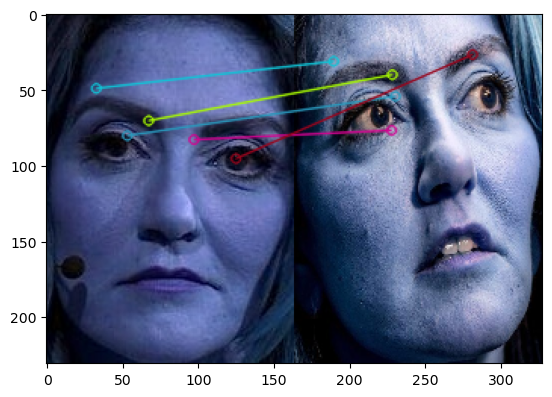

True

In [125]:
# Read two images as grayscale
img_1 = cv2.imread(image1_path)
img_2 = cv2.imread(image2_path)

img1 = cv2.imread(image1_path,0)
img2 = cv2.imread(image2_path,0)

img1, img2 = match_image_sizes(img1, img2, "min")
img_1, img_2 = match_image_sizes(img_1, img_2, "min")

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Initiate ORB detector
# sift = cv2.ORB_create()

# Detect and compute the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Create BFMatcher object
bf = cv2.BFMatcher()
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  # for orb
matches = bf.knnMatch(des1,des2, k=2)
# matches = bf.match(des1, des2)

# Apply ratio test
good = []
for m,n in matches:
   if m.distance < 0.75*n.distance:
      good.append([m])
if len(good) > 2:
    print("Good match")
else:
    print("no match")
print(f"There were {len(good)} matches")

# Plot the resulting (matching) keypoints
img3 = cv2.drawMatchesKnn(img_1,kp1,img_2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

os.makedirs("examples/feature_detection", exist_ok=True)
cv2.imwrite("examples/feature_detection/example_feature_detection0.jpg", img3)

## Example of csv file

In [3]:
import sqlite3
import pandas as pd
import json
import ast
import re
import cv2

In [17]:
path = "visualization/databases/small_subset_politicians.db"
conn = sqlite3.connect(path)

q = """SELECT * FROM main"""
df = pd.read_sql_query(q, conn)
df

index                                               id  \
0      0  2488778_jpg.rf.5a96b3f340169f081f384e77c9e7f6f6   
1      1  2488800_jpg.rf.b5779f7a3d4e777543093bf2e1798d05   
2      2  2488855_jpg.rf.c3b75d5f69035df2d9b2ca469cac5aec   
3      3  2488763_jpg.rf.b169daaf5479c38dd5c15a3433b7c0f1   
4      4  2488934_jpg.rf.062963d026d23a76401072d601e9e2d0   
5      5  2489181_jpg.rf.656f45c685803b434b6223f946032b69   
6      6  2488814_jpg.rf.d2c0f2dbab7d6122702b75587c9f1f13   
7      7  2488941_jpg.rf.cc8fe043692971011ddb84c9c09ebb77   
8      8  2488891_jpg.rf.099c86d746d16586f8a95a062e393303   
9      9  2488894_jpg.rf.f0c60c1a1e8d0d793528b3ed47ef0781   

                                                 img  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[52, 51, 60], [56, 55, 64], [62, 61, 70], [6...  
2  [[[60, 132, 102], [60, 132, 102], [60, 132, 10...  
3  [[[1, 68, 107], [1, 68, 107], [1, 68, 107], [1...  
4  [[[6, 0, 1], [6, 0, 1], [5, 0, 1], [4, 0, 0], ...  
5  [[[154, 166, 172], [154, 166, 172], [155, 165,...  
6  [[[168, 156, 152], [168, 156, 152], [168, 155,...  
7  [[[141, 37, 2], [139, 35, 0], [138, 34, 0], [1...  
8  [[[42, 48, 53], [42, 48, 53], [41, 47, 52], [3...  
9  [[[125, 129, 134], [222, 226, 231], [249, 252,...

In [19]:
save_path = "examples/example_csv.csv"
df["id"] = df["id"].apply(lambda x: int(x.split("_")[0]))
df_info = pd.read_parquet("data/Embedding_On_The_Wall/full_df_clf_corrected.parquet")[["id", "url", "category"]]

df = pd.merge(df, df_info, on="id")
df["img"] = df["img"].apply(json.loads)
# df["img"] = df["img"].apply(lambda x: x[:2])
df["category"] = df["category"].apply(lambda x: re.findall(r"'(.*?)'", x))
df["category"] = df["category"].apply(json.dumps)
df[["id", "url", "category", "img"]].to_csv(save_path, index=False)
df[["id", "url", "category", "img"]]

id                                 url  \
0  2488778  https://www.nos.nl/artikel/2488778   
1  2488800  https://www.nos.nl/artikel/2488800   
2  2488855  https://www.nos.nl/artikel/2488855   
3  2488763  https://www.nos.nl/artikel/2488763   
4  2488934  https://www.nos.nl/artikel/2488934   
5  2489181  https://www.nos.nl/artikel/2489181   
6  2488814  https://www.nos.nl/artikel/2488814   
7  2488941  https://www.nos.nl/artikel/2488941   
8  2488891  https://www.nos.nl/artikel/2488891   
9  2488894  https://www.nos.nl/artikel/2488894   

                             category  \
0  ["Op weg naar TK2023", "Politiek"]   
1  ["Op weg naar TK2023", "Politiek"]   
2  ["Op weg naar TK2023", "Politiek"]   
3        ["Binnenland", "Buitenland"]   
4  ["Op weg naar TK2023", "Politiek"]   
5  ["Op weg naar TK2023", "Politiek"]   
6                      ["Binnenland"]   
7  ["Op weg naar TK2023", "Politiek"]   
8  ["Op weg naar TK2023", "Politiek"]   
9        ["Binnenland", "Buitenland"]   

                                                 img  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[52, 51, 60], [56, 55, 64], [62, 61, 70], [6...  
2  [[[60, 132, 102], [60, 132, 102], [60, 132, 10...  
3  [[[1, 68, 107], [1, 68, 107], [1, 68, 107], [1...  
4  [[[6, 0, 1], [6, 0, 1], [5, 0, 1], [4, 0, 0], ...  
5  [[[154, 166, 172], [154, 166, 172], [155, 165,...  
6  [[[168, 156, 152], [168, 156, 152], [168, 155,...  
7  [[[141, 37, 2], [139, 35, 0], [138, 34, 0], [1...  
8  [[[42, 48, 53], [42, 48, 53], [41, 47, 52], [3...  
9  [[[125, 129, 134], [222, 226, 231], [249, 252,...

In [21]:
df = pd.read_csv(save_path)
df

id                                 url  \
0  2488778  https://www.nos.nl/artikel/2488778   
1  2488800  https://www.nos.nl/artikel/2488800   
2  2488855  https://www.nos.nl/artikel/2488855   
3  2488763  https://www.nos.nl/artikel/2488763   
4  2488934  https://www.nos.nl/artikel/2488934   
5  2489181  https://www.nos.nl/artikel/2489181   
6  2488814  https://www.nos.nl/artikel/2488814   
7  2488941  https://www.nos.nl/artikel/2488941   
8  2488891  https://www.nos.nl/artikel/2488891   
9  2488894  https://www.nos.nl/artikel/2488894   

                             category  \
0  ["Op weg naar TK2023", "Politiek"]   
1  ["Op weg naar TK2023", "Politiek"]   
2  ["Op weg naar TK2023", "Politiek"]   
3        ["Binnenland", "Buitenland"]   
4  ["Op weg naar TK2023", "Politiek"]   
5  ["Op weg naar TK2023", "Politiek"]   
6                      ["Binnenland"]   
7  ["Op weg naar TK2023", "Politiek"]   
8  ["Op weg naar TK2023", "Politiek"]   
9        ["Binnenland", "Buitenland"]   

                                                 img  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[52, 51, 60], [56, 55, 64], [62, 61, 70], [6...  
2  [[[60, 132, 102], [60, 132, 102], [60, 132, 10...  
3  [[[1, 68, 107], [1, 68, 107], [1, 68, 107], [1...  
4  [[[6, 0, 1], [6, 0, 1], [5, 0, 1], [4, 0, 0], ...  
5  [[[154, 166, 172], [154, 166, 172], [155, 165,...  
6  [[[168, 156, 152], [168, 156, 152], [168, 155,...  
7  [[[141, 37, 2], [139, 35, 0], [138, 34, 0], [1...  
8  [[[42, 48, 53], [42, 48, 53], [41, 47, 52], [3...  
9  [[[125, 129, 134], [222, 226, 231], [249, 252,...

## Face Recognition

In [4]:
from sklearn.pipeline import Pipeline
import os
import shutil

In [16]:
# Create a test dataset

dest = "../data_for_vis"
p = "face_clustering/data/celebrity-face-image-dataset"

# Find all image paths in this folder
image_paths = [
    os.path.join(root, file).replace("\\", "/")
    for root, _, files in os.walk(p)
    for file in files
    if file.lower().endswith((".jpg", ".jpeg", ".png"))
]

# print(image_paths)
for i in image_paths:
    shutil.copy(i, f"{dest}/{i.split('/')[-1]}")

Use the 'New Data' page of the interactive visualization to process the data, save it as test_cfi.

In [1]:
import pandas as pd

In [5]:
df = pd.read_csv("examples/embeddings_on_the_wall.csv")
print(df)
df[:10].to_csv("examples/example.csv")

          id                                                url  \
0    2488763                 https://www.nos.nl/artikel/2488763   
1    2488778                 https://www.nos.nl/artikel/2488778   
2    2488800                 https://www.nos.nl/artikel/2488800   
3    2488814                 https://www.nos.nl/artikel/2488814   
4    2488823                 https://www.nos.nl/artikel/2488823   
..       ...                                                ...   
291  6295105                 https://www.nu.nl/stelling/6295105   
292  6295127                 https://www.nu.nl/politiek/6295127   
293  6295172            https://www.nu.nl/formatie-2023/6295172   
294  6295260  https://www.nu.nl/gebaseerd-op-jullie-vragen/6...   
295  6295717                 https://www.nu.nl/algemeen/6295717   

                                              category  \
0                         ["Binnenland", "Buitenland"]   
1                   ["Op weg naar TK2023", "Politiek"]   
2                   [

In [9]:
import seaborn as sns

In [107]:
img0 = cv2.imread("image.png")
img1 = cv2.imread("image (1).png")
# img1 = cv2.imread("data/Face-Detection-Dataset (Kaggle)/images/train/0a0de81fc9d37ade.jpg")
# img2 = cv2.imread("data/WIDER_face/train/images/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_39.jpg")
# img3 = cv2.imread("data/WIDER_face/train/images/0--Parade/0_Parade_marchingband_1_17.jpg")

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

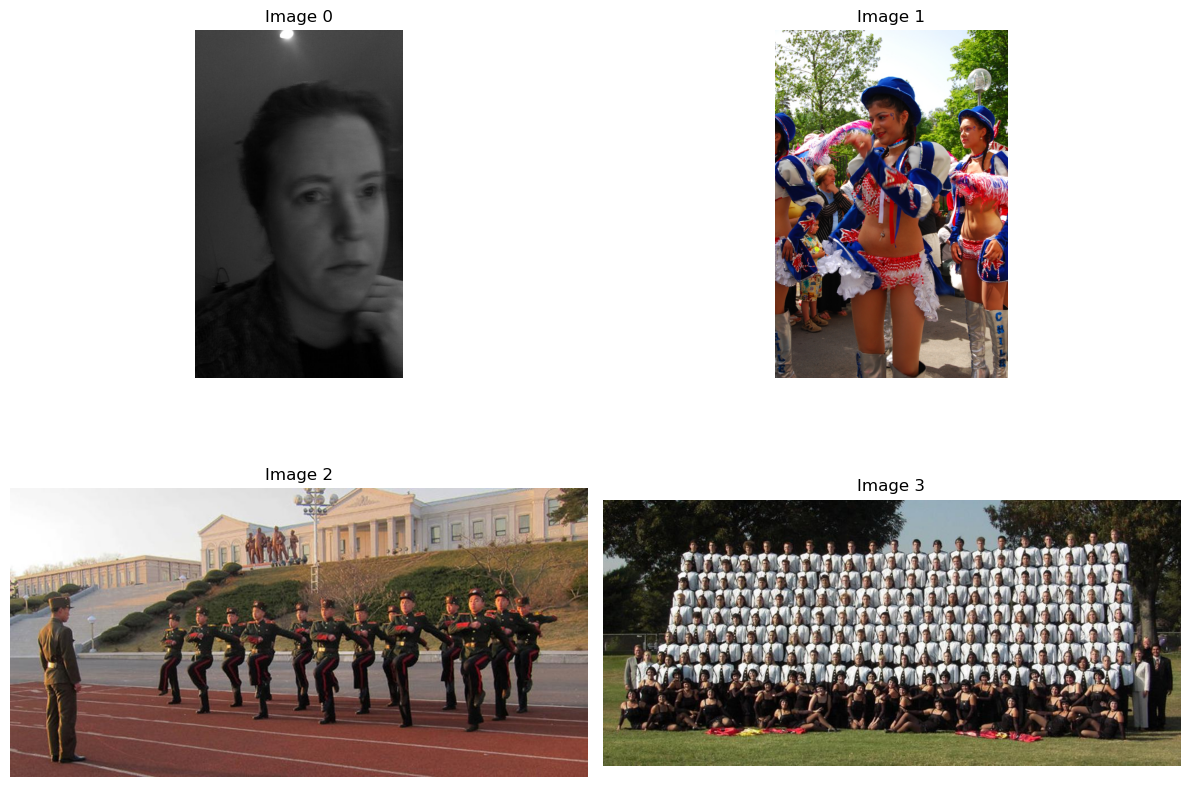

In [29]:
# Create a figure with a custom layout
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

# Top row: side-by-side
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Bottom row: stacked
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Plot images
ax0.imshow(img0)
ax0.axis("off")
ax0.set_title("Image 0")

ax1.imshow(img1)
ax1.axis("off")
ax1.set_title("Image 1")

ax2.imshow(img2)
ax2.axis("off")
ax2.set_title("Image 2")

ax3.imshow(img3)
ax3.axis("off")
ax3.set_title("Image 3")

# Adjust layout
plt.tight_layout()
plt.show()

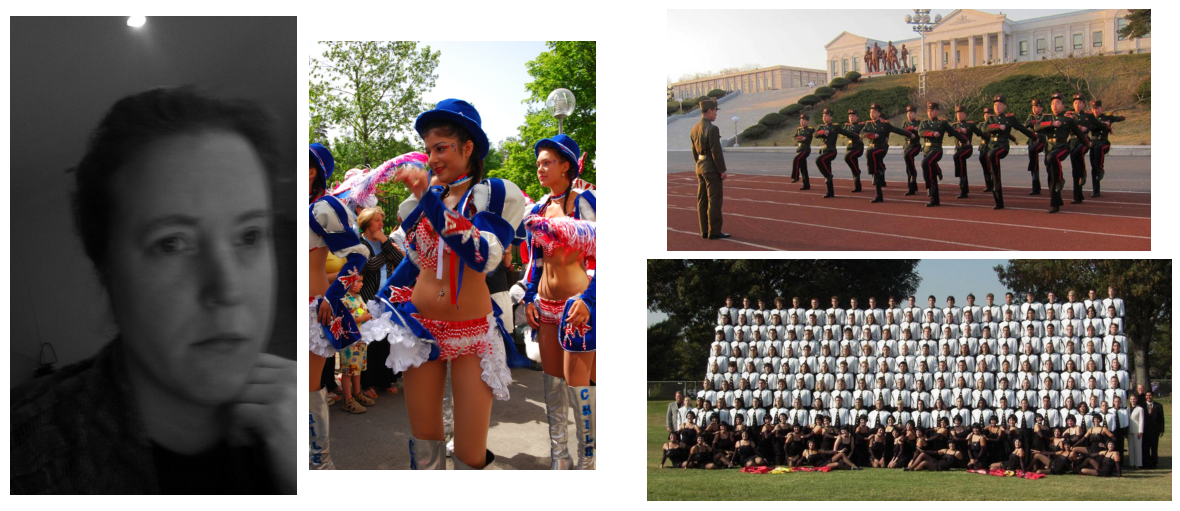

In [43]:
# Create figure with constrained layout to help with spacing
fig = plt.figure(figsize=(12, 5), constrained_layout=True)

# Create two subfigures side-by-side
subfigs = fig.subfigures(1, 2, width_ratios=[1, 1])

# Left: side-by-side images
axs_left = subfigs[0].subplots(1, 2)
axs_left[0].imshow(img0)
axs_left[0].axis('off')
axs_left[1].imshow(img1)
axs_left[1].axis('off')

# Right: stacked vertically with NO space
axs_right = subfigs[1].subplots(
    2, 1, 
    gridspec_kw={"hspace": 0}
)
axs_right[0].imshow(img2)
axs_right[0].axis('off')

axs_right[1].imshow(img3)
axs_right[1].axis('off')

plt.show()

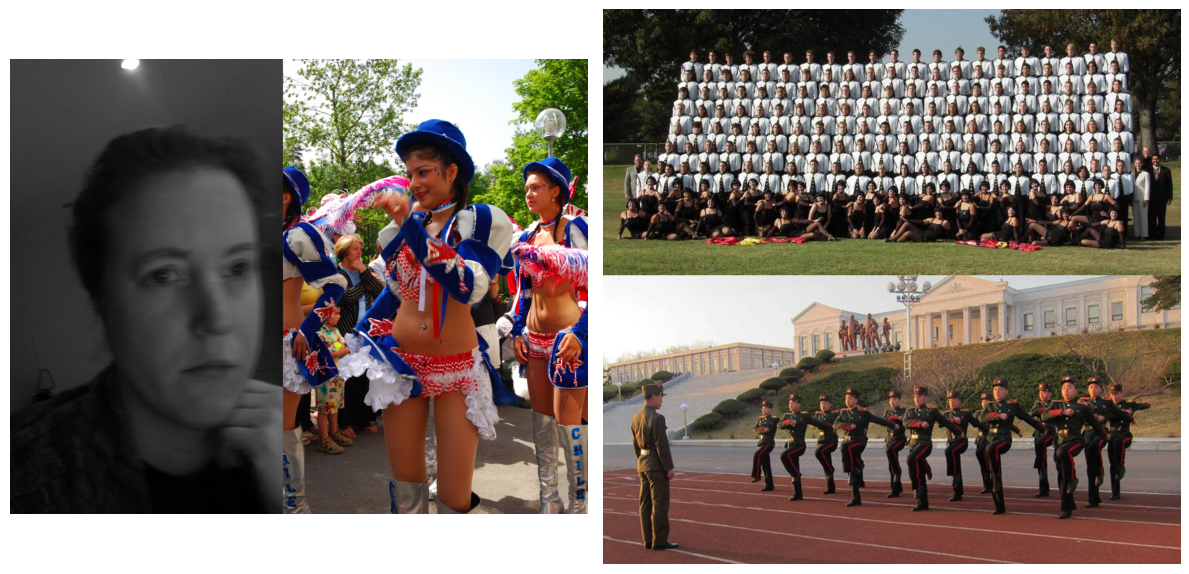

In [111]:
# Create a 1-row, 2-column plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plt.suptitle(f"Example images for the face detection train and validation data", fontsize=20)

# Display the first image
axs[0].imshow(img1)
axs[0].axis('off')
# axs[0].set_title("Face Detection Dataset")

# Display the second image
axs[1].imshow(img0)
axs[1].axis('off')
# axs[1].set_title("WIDER FACE")

# Remove extra spacing
plt.tight_layout()
plt.savefig("examples_fd_dataset.pdf")

In [103]:
img0 = cv2.imread("example_cel.png")
img1 = cv2.imread("example_EOTW.png")
# img1 = cv2.imread("data/Face-Detection-Dataset (Kaggle)/images/train/0a0de81fc9d37ade.jpg")
# img2 = cv2.imread("data/WIDER_face/train/images/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_39.jpg")
# img3 = cv2.imread("data/WIDER_face/train/images/0--Parade/0_Parade_marchingband_1_17.jpg")

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

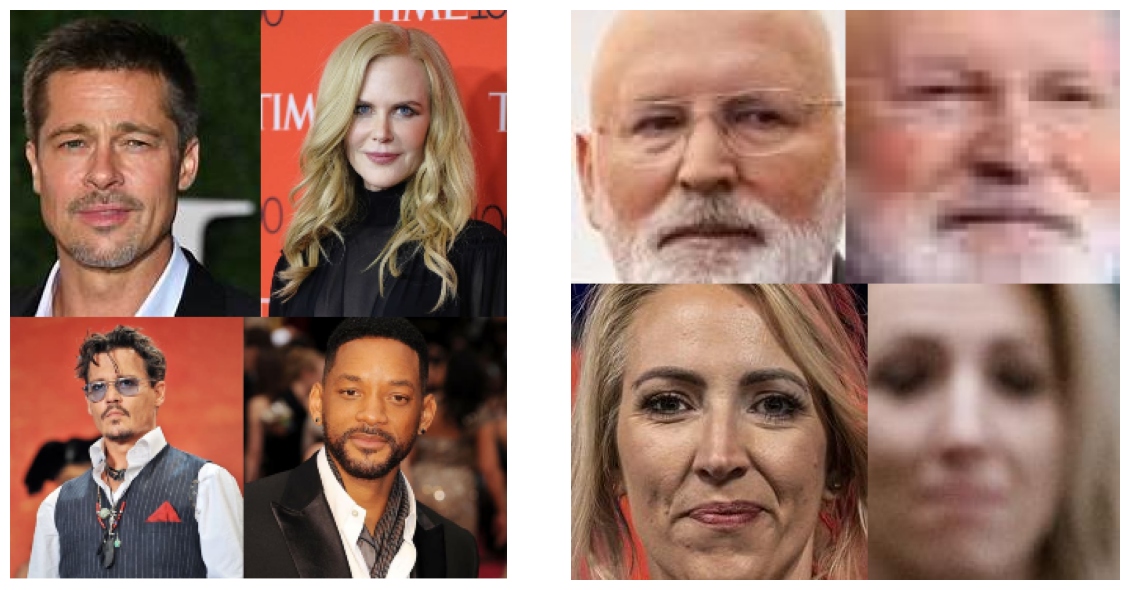

In [105]:
# Create a 1-row, 2-column plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plt.suptitle(f"Example images for the face detection train and validation data", fontsize=20)

# Display the first image
axs[0].imshow(img0)
axs[0].axis('off')
# axs[0].set_title("Face Detection Dataset")

# Display the second image
axs[1].imshow(img1)
axs[1].axis('off')
# axs[1].set_title("WIDER FACE")

# Remove extra spacing
plt.tight_layout()
plt.savefig("examples_fc_dataset.pdf")